## SCIP example

In [1]:
from optiwindnet.importer import load_repository
from optiwindnet.svg import svgplot
from optiwindnet.mesh import make_planar_embedding
from optiwindnet.interarraylib import G_from_S
from optiwindnet.heuristics import EW_presolver
from optiwindnet.MILP import solver_factory, ModelOptions

### Initialize Sheringham Shoal

In [2]:
locations = load_repository()

In [3]:
L = locations.sheringham
capacity = 6

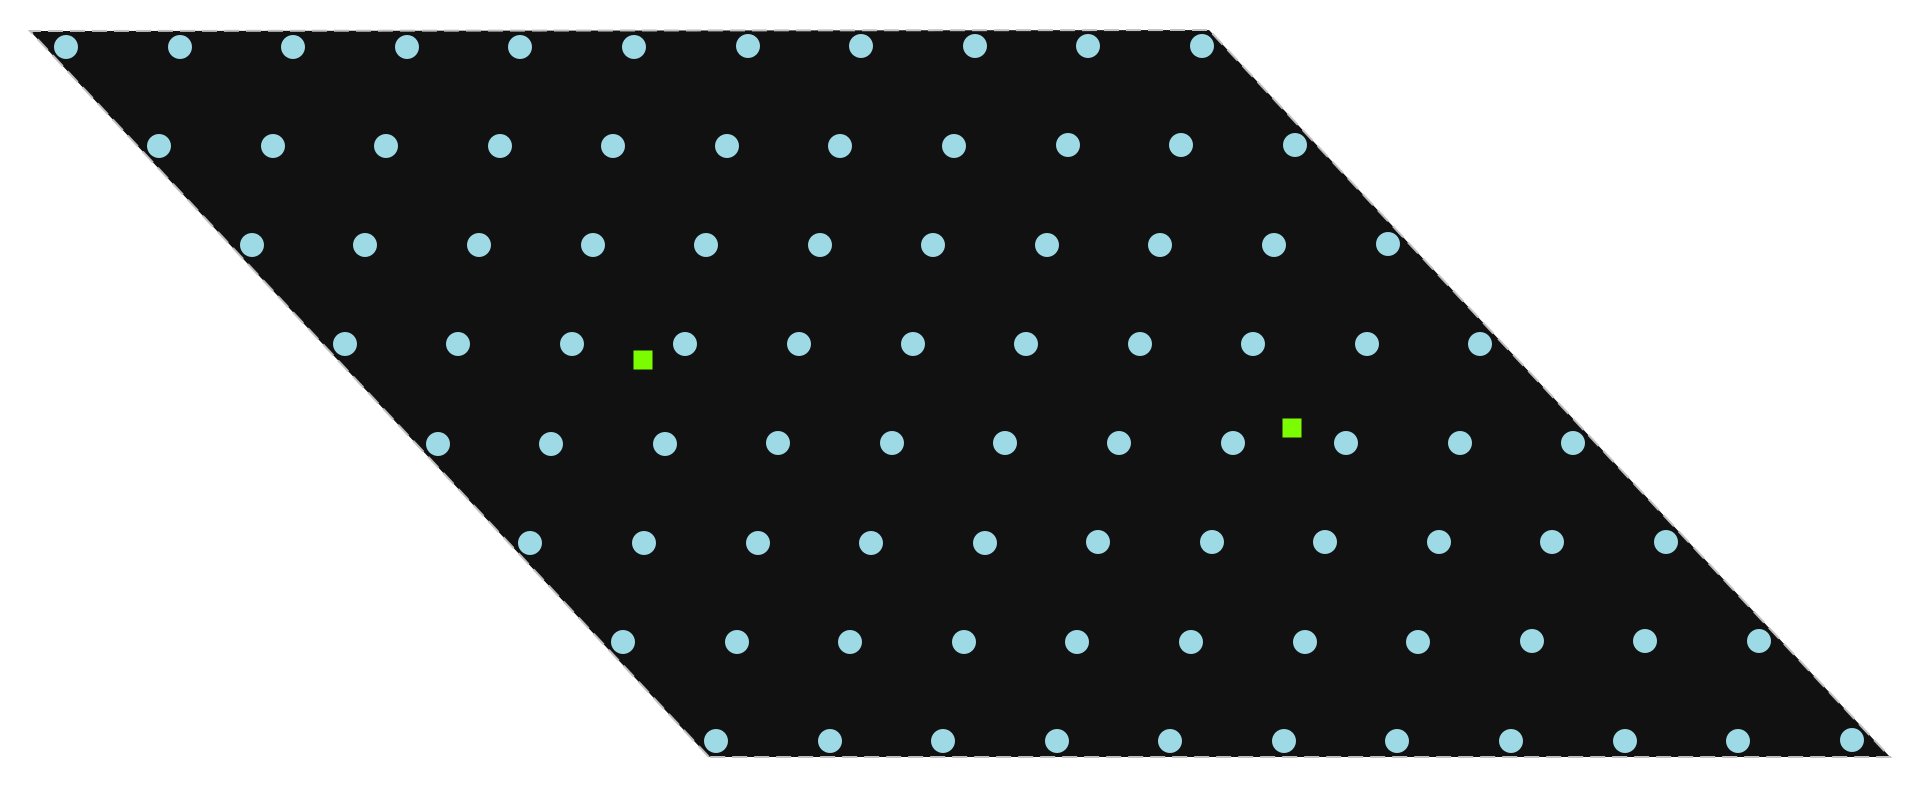

In [4]:
svgplot(L)

### Optimize Sheringham Shoal

In [5]:
P, A = make_planar_embedding(L)

Initial heuristic solution to warm-start the solver:

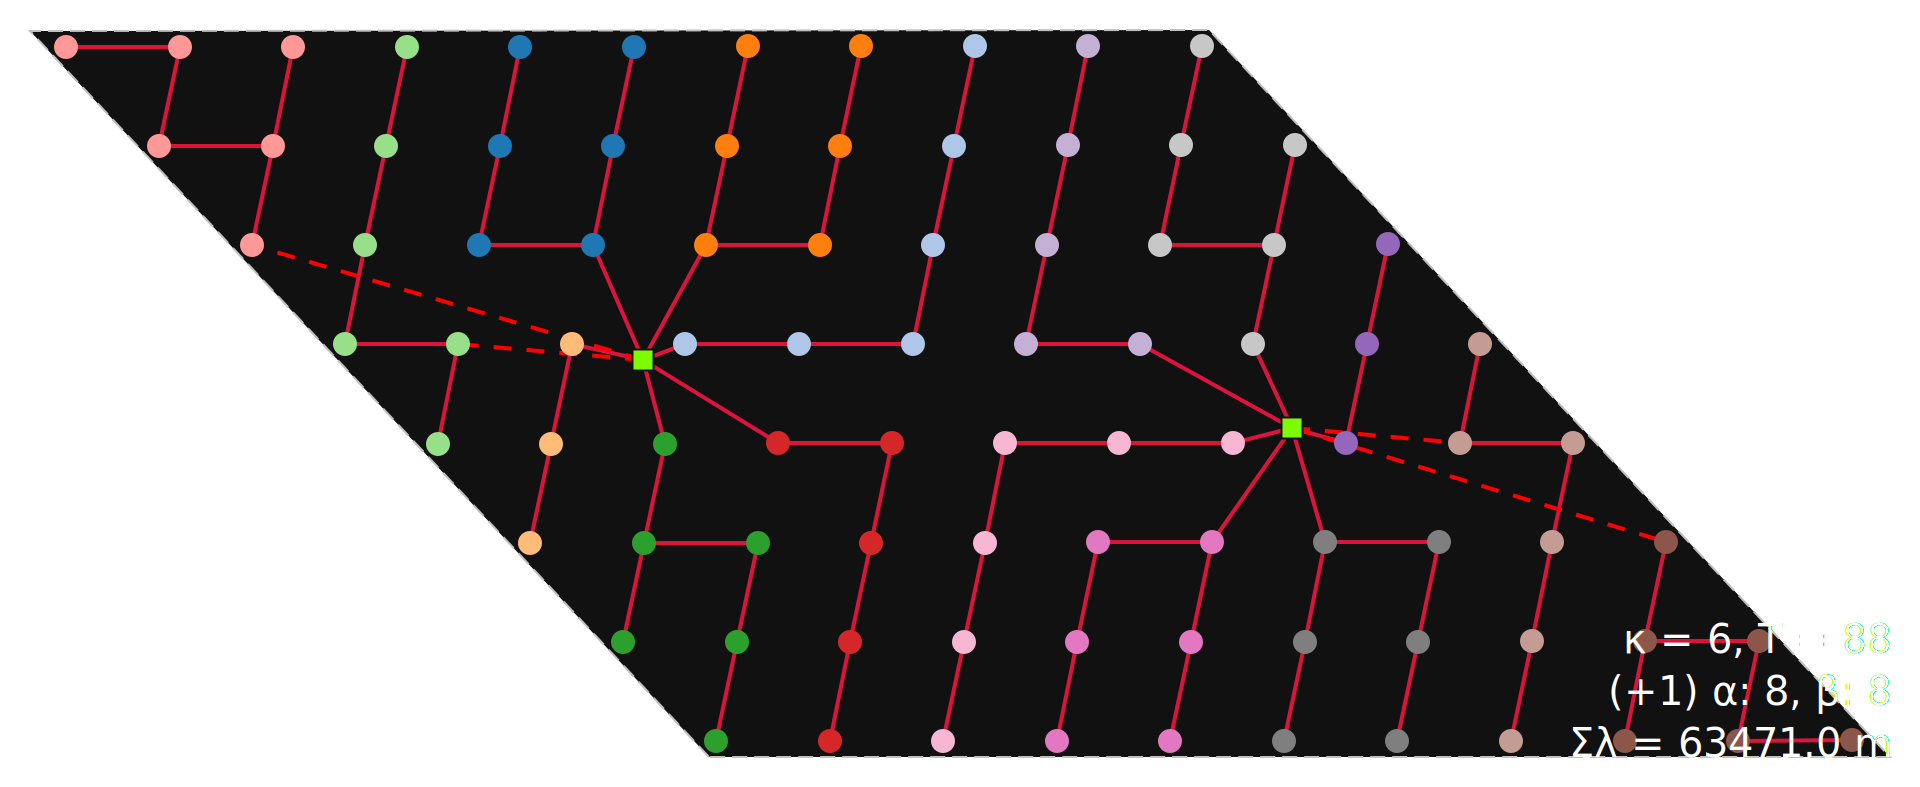

In [6]:
Sʹ = EW_presolver(A, capacity=capacity)
Gʹ = G_from_S(Sʹ, A)
svgplot(Gʹ)

In [7]:
solver = solver_factory('scip')

In [8]:
solver.set_problem(
    P, A,
    capacity=Sʹ.graph['capacity'],
    model_options=ModelOptions(
        topology="branched",
        feeder_route="segmented",
        feeder_limit="unlimited",
    ),
    warmstart=Sʹ,
)

Solver <scip> is not capable of warm-starting.


SCIP's Pyomo API does not offer the warm-starting capability yet.

In [9]:
solver.solve(
    mip_gap=0.005,
    time_limit=180,
    verbose=True,
)

SCIP version 9.2.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 7.1.4] [GitHash: 416226a4f8]
Copyright (c) 2002-2025 Zuse Institute Berlin (ZIB)

External libraries: 
  SoPlex 7.1.4         Linear programming solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 7c53d552]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (github.com/coin-or/CppAD)
  ZLIB 1.3.1           General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.3.0            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.6.2          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  AMPL/MP 690e9e7      AMPL .nl file reader library (github.com/ampl/mp)
  PaPILO 2.4.2         parallel presolve for integer and linear optimization (github.com/scipopt/papilo) (built with TBB) [GitHash: 4b399c4c]
  Nauty 2.8.8          Computing Graph Automor

SolutionInfo(runtime=<pyomo.opt.results.container.UndefinedData object at 0x00000221BD036420>, bound=60521.5004916549, objective=62734.8181165685, relgap=0.03528052987738006, termination='maxTimeLimit')

In [10]:
S, G = solver.get_solution()

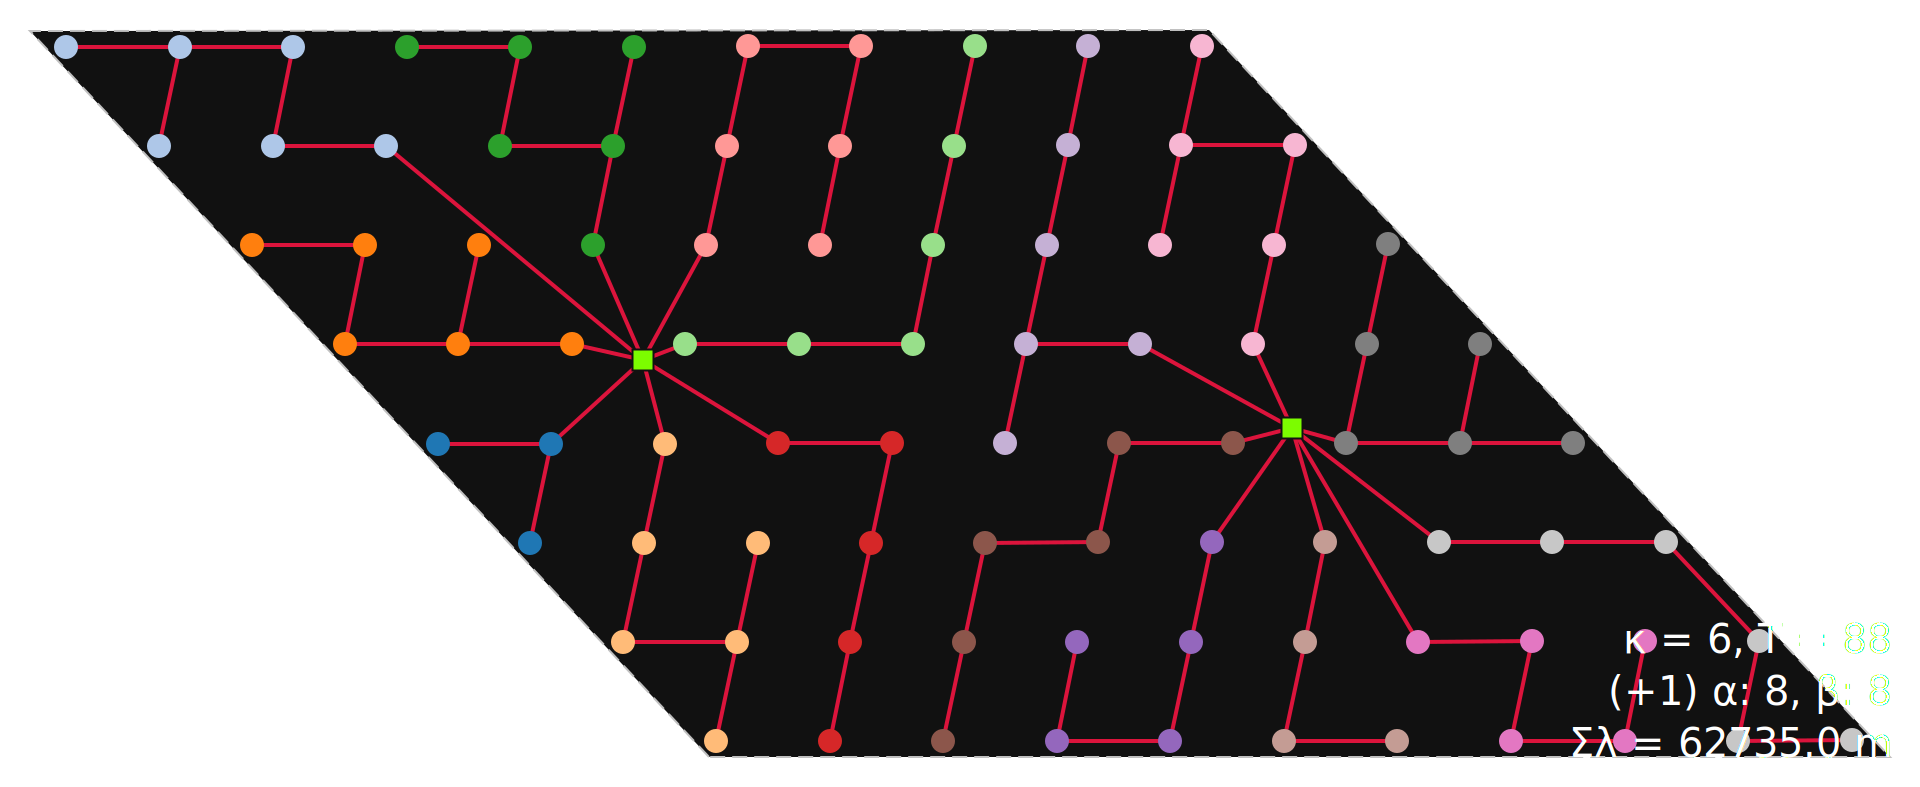

In [11]:
svgplot(G)